# DBBA Coursework 1

#### Name: Teofebano Kristo       
#### Student Number: S2594631

--------------------------------------------------------------------------------------------------------------------------------------------

### Instructions

#### Academic Misconduct

Please remember the good scholarly practice requirements of the University regarding work for
credit. You can find guidance at the School page

https://web.inf.ed.ac.uk/infweb/admin/policies/academic-misconduct

This also has links to the relevant University pages. 

**You are not allowed to collaborate with other students on this assignment or to ask or answer questions about the contents of the assignment. If you do not understand a specific question, ask Valerio and Ogy on Piazza.**

#### Submission Instructions

All the analysis must be done in this Jupyter Notebook and you should have a separate written report (without code) saved in PDF. Please fill out the fields bellow with the necessary code(remember to comment your code well) and discussion where needed. Code will generally
not be marked, but it will be checked by the markers to ensure that all the analysis is properly
done and the work is yours (i.e. there was no plagiarism). Focus on analysing the results you obtain as this is the main part that will be marked. Report your findings in a PDF file where you do not include any code but just the figures obtained and the conclusions you draw, i.e. plots and analysis. You will have to submit your files (final Jupyter Notebook and PDF) on Learn. Name your files with your
student number. For instance, if your student number is S123456789, you must submit a file
S123456789.zip containing the python source code and answers to the questions (PDF).

#### General Instructions 
In this coursework, you will analyse a real-world temporal network based on what you have learned in
class. Many exercises will require you to discuss the results of your analysis, some other will leave
you the choice of which algorithm to use for a particular task. This is by design because this
coursework assesses whether you understand network science and whether you can apply it to
real-world networks. For this reason, if you realise you need to make assumptions to answer a
question, do so and always, always motivate your assumptions and answers!

**Warning:** Some network metrics might require some time to compute. Please consider this when
doing the coursework and allow enough time to perform the required computations. Also
remember that you can use the School’s DICE machines, which can be let to run!

--------------------------------------------------------------------------------------------------------------------------------------------

#### Assignment Premises

You have been hired as a data analyst in the newly founded investment company DBBA Capital and have been tasked with the analysis of the investment patterns of one of our major competitors: Fairholme Capital, managed by Bruce Berkowitz. 

DBBA Capital wants you to evaluate the investment patterns of Fairholme Capital in relation to other superinvestors and evaluate the change in investment patterns during the pandemic. They have provided you with data about different superinvestors and the companies they invested in for each quarter spanning from quarter 1 (Q1) of 2019 to quarter 2 (Q2) of 2023 (that you can find in the folder named "Assignment Data"). 

The first column of each file represents the investors and the remaining columns represent the companies each investor invested in. First, familiarlise yourself with the data, and then, follow the steps bellow to perform the necessary analysis.

**TIP** When you believe it might help, make use of the information you have on the portfolio composition to comment and discuss your results.

# Library Management

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
%matplotlib inline

import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

from tabulate import tabulate
import statistics
import math

# Methods

In [2]:
# Drawing Network
def draw_graphviz(G, id, nodecolor, spreadprogram='neato'):
    # init plt     
    plt.figure(id, figsize=(15,15))
    
    # use pydot and graphviz for better layout    
    pos = graphviz_layout(G, prog = spreadprogram)
    color_map = []
    for node in G:
        if node == 'Bruce Berkowitz - Fairholme Capital':
            # highlighting Fairholme Capital with different color             
            color_map.append('orange')
        else: 
            color_map.append(nodecolor)

    nx.draw(G, pos, node_color = color_map, with_labels = True, node_size=1000, font_size=8)
    
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    
    plt.title(id, fontsize=16, fontweight="bold")
    
    # draw
    plt.show()

In [3]:
# Populate Network
def populate_graph(G, dataframe):
    for index, row in dataframe.iterrows():
        investors = dataframe.iloc[:, 0]
        G.add_nodes_from(investors);
        
    for i in range(len(investors)):
        investori = dataframe.iloc[i,0]
        stocksi = dataframe.iloc[i,1:]
        clean_stocksi = stocksi.dropna()
        
        for j in range(i + 1, len(investors)):
            investorj = dataframe.iloc[j,0]
            stocksj = dataframe.iloc[j,1:]
            clean_stocksj = stocksj.dropna()
            
            common_values = list(set(clean_stocksi) & set(clean_stocksj))
            
            if len(common_values) > 0:
                G.add_edge(investori, investorj)
                G[investori][investorj]['weight'] = len(common_values)
                
def add_strength_to_nodes(G):
    strengths = {}
    for node in G.nodes():
        strength = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
        strengths[node] = strength
    
    nx.set_node_attributes(G, strengths, "strength")
    
def add_clustering_to_nodes(G):
    clusterings = {}
    for node in G.nodes():
        clustering = nx.clustering(G, node)
        clusterings[node] = clustering
    
    nx.set_node_attributes(G, clusterings, "clustering")

In [4]:
# Extract Giant Component
def extract_giant_component_from_graph(G):
    G_CC = sorted(nx.connected_components(G), key=len, reverse=True)
    Giant_G = G.subgraph(G_CC[0])
    
    return Giant_G

In [5]:
# Build Ego Network
def build_ego_network_for_node(G, node):
    return nx.ego_graph(G, node)

In [53]:
# Calculate Network Summary Per Graph
def get_network_summary_for_graph(G):
    nodesCount = G.number_of_nodes()
    
    edgesCount = G.number_of_edges()

    density = nx.density(G)
    
    averageClustering = nx.average_clustering(G)

    degrees = [val for (node, val) in G.degree()]
    sumDegrees = sum(degrees)
    averageDegrees = sumDegrees / nodesCount

    # index 0 is node name, index 1 is weights for that particular node
    weights = G.degree(weight='weight')
    averageStrength = sum(weight[1] for weight in weights) / nodesCount 

    degreeAssortativity = nx.degree_assortativity_coefficient(G)
    
    strengthAssortativity = nx.numeric_assortativity_coefficient(G, "strength")
    
    clusteringAssortativity = nx.numeric_assortativity_coefficient(G, "clustering")
    
    return {
        "nodesCount": nodesCount, 
        "edgesCount": edgesCount, 
        "density": density, 
        "averageClustering": averageClustering, 
        "averageDegrees": averageDegrees, 
        "averageStrength": averageStrength, 
        "degreeAssortativity": degreeAssortativity, 
        "strengthAssortativity": strengthAssortativity, 
        "clusteringAssortativity": clusteringAssortativity
    }


In [115]:
# Print Statistic Summary for Multiple Graphs
def get_statistics_for_graphs(networkSummary):
    # Nodes Count
    maxValNodesCount = max(quarterData['nodesCount'] for quarterData in networkSummary.values())
    minValNodesCount = min(quarterData['nodesCount'] for quarterData in networkSummary.values())
    meanValNodesCount = statistics.mean(quarterData['nodesCount'] for quarterData in networkSummary.values())
    medianValNodesCount = statistics.median(quarterData['nodesCount'] for quarterData in networkSummary.values())
    standardDeviationValNodesCount = statistics.stdev(quarterData['nodesCount'] for quarterData in networkSummary.values())
    
    # Edges Count
    maxValEdgesCount = max(quarterData['edgesCount'] for quarterData in networkSummary.values())
    minValEdgesCount = min(quarterData['edgesCount'] for quarterData in networkSummary.values())
    meanValEdgesCount = statistics.mean(quarterData['edgesCount'] for quarterData in networkSummary.values())
    medianValEdgesCount = statistics.median(quarterData['edgesCount'] for quarterData in networkSummary.values())
    standardDeviationValEdgesCount = statistics.stdev(quarterData['edgesCount'] for quarterData in networkSummary.values())
    
    # Density
    maxValDensity = max(quarterData['density'] for quarterData in networkSummary.values())
    minValDensity = min(quarterData['density'] for quarterData in networkSummary.values())
    meanValDensity = statistics.mean(quarterData['density'] for quarterData in networkSummary.values())
    medianValDensity = statistics.median(quarterData['density'] for quarterData in networkSummary.values())
    standardDeviationValDensity = statistics.stdev(quarterData['density'] for quarterData in networkSummary.values())
    
    # Average Clustering
    maxValAverageClustering = max(quarterData['averageClustering'] for quarterData in networkSummary.values())
    minValAverageClustering = min(quarterData['averageClustering'] for quarterData in networkSummary.values())
    meanValAverageClustering = statistics.mean(quarterData['averageClustering'] for quarterData in networkSummary.values())
    medianValAverageClustering = statistics.median(quarterData['averageClustering'] for quarterData in networkSummary.values())
    standardDeviationValAverageClustering = statistics.stdev(quarterData['averageClustering'] for quarterData in networkSummary.values())
    
    # Average Degrees
    maxValAverageDegrees = max(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    minValAverageDegrees = min(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    meanValAverageDegrees = statistics.mean(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    medianValAverageDegrees = statistics.median(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    standardDeviationValAverageDegrees = statistics.stdev(quarterData['averageDegrees'] for quarterData in networkSummary.values())
    
    # Average Strength
    maxValAverageStrength = max(quarterData['averageStrength'] for quarterData in networkSummary.values())
    minValAverageStrength = min(quarterData['averageStrength'] for quarterData in networkSummary.values())
    meanValAverageStrength = statistics.mean(quarterData['averageStrength'] for quarterData in networkSummary.values())
    medianValAverageStrength = statistics.median(quarterData['averageStrength'] for quarterData in networkSummary.values())
    standardDeviationValAverageStrength = statistics.stdev(quarterData['averageStrength'] for quarterData in networkSummary.values())
    
    # Degree Assortativity
    data = [quarterData['degreeAssortativity'] for quarterData in networkSummary.values()]
    filteredData = [x for x in data if not math.isnan(x)]
    
    maxValDegreeAssortativity = max(filteredData)
    minValDegreeAssortativity = min(filteredData)
    meanValDegreeAssortativity = statistics.mean(filteredData)
    medianValDegreeAssortativity = statistics.median(filteredData)
    
    standardDeviationValDegreeAssortativity = 'N/A'
    if len(filteredData) > 1 :
        standardDeviationValDegreeAssortativity = statistics.stdev(filteredData)
    
    # Strength Assortativity
    data = [quarterData['strengthAssortativity'] for quarterData in networkSummary.values()]
    filteredData = [x for x in data if not math.isnan(x)]
    
    maxValStrengthAssortativity = max(filteredData)
    minValStrengthAssortativity = min(filteredData)
    meanValStrengthAssortativity = statistics.mean(filteredData)
    medianValStrengthAssortativity = statistics.median(filteredData)
    
    standardDeviationValStrengthAssortativity = 'N/A'
    if len(filteredData) > 1 :
        standardDeviationValStrengthAssortativity = statistics.stdev(filteredData)
    
    # Clustering Assortativity
    data = [quarterData['clusteringAssortativity'] for quarterData in networkSummary.values()]
    filteredData = [x for x in data if not math.isnan(x)]
    
    maxValClusteringAssortativity = max(filteredData)
    minValClusteringAssortativity = min(filteredData)
    meanValClusteringAssortativity = statistics.mean(filteredData)
    medianValClusteringAssortativity = statistics.median(filteredData)
    
    standardDeviationValClusteringAssortativity = 'N/A'
    if len(filteredData) > 1 :
        standardDeviationValClusteringAssortativity = statistics.stdev(filteredData)
    
    data = [["# Nodes", maxValNodesCount, minValNodesCount, meanValNodesCount, medianValNodesCount, standardDeviationValNodesCount],
           ["# Edges", maxValEdgesCount, minValEdgesCount, meanValEdgesCount, medianValEdgesCount, standardDeviationValEdgesCount],
           ["Density", maxValDensity, minValDensity, meanValDensity, medianValDensity, standardDeviationValDensity],
           ["Avg. Clustering", maxValAverageClustering, minValAverageClustering, meanValAverageClustering, medianValAverageClustering, standardDeviationValAverageClustering],
           ["Avg. Degrees", maxValAverageDegrees, minValAverageDegrees, meanValAverageDegrees, medianValAverageDegrees, standardDeviationValAverageDegrees],
           ["Avg. Strength", maxValAverageStrength, minValAverageStrength, meanValAverageStrength, medianValAverageStrength, standardDeviationValAverageStrength],
           ["Degree Assort.", maxValDegreeAssortativity, minValDegreeAssortativity, meanValDegreeAssortativity, medianValDegreeAssortativity, standardDeviationValDegreeAssortativity],
           ["Strength Assort.", maxValStrengthAssortativity, minValStrengthAssortativity, meanValStrengthAssortativity, medianValStrengthAssortativity, standardDeviationValStrengthAssortativity],
           ["Clustering Assort.", maxValClusteringAssortativity, minValClusteringAssortativity, meanValClusteringAssortativity, medianValClusteringAssortativity, standardDeviationValClusteringAssortativity]]
    print (tabulate(data, headers=["Properties", 
                                   "max", 
                                   "min", 
                                   "mean", 
                                   "median", 
                                   "SD"
                                  ]))

#### Part 1: Network Creation

**Task 1.1 (7 marks)**<br>
In the field below, load the first Excel dataset ("2019_Q1.xlsx") and create a network out of the investors and companies in the following manner:

- the nodes of the network are all the investors in the first column of the dataset
- two investors (nodes) are connected with an edge if the have invested in the same company (e.g. Christopher Bloomstran - Semper Augustus and David Abrams - Abrams Capital Management will be connected because they both invested in GOOGL). 
- if two investors have invested in more than one common comapny, do *not* assign multiple edges between them. Instead, assign the number of common companies they have invested in as a weight to the edge connecting them.

After you built the network, extract the largest connected component and plot it. Remember to add the edge weights in your plot.

In [8]:
#CODE HERE
df_2019_Q1 = pd.read_excel('./Assignment_Data/2019_Q1.xlsx', header=None)

G_2019_Q1 = nx.Graph()
populate_graph(G_2019_Q1, df_2019_Q1)

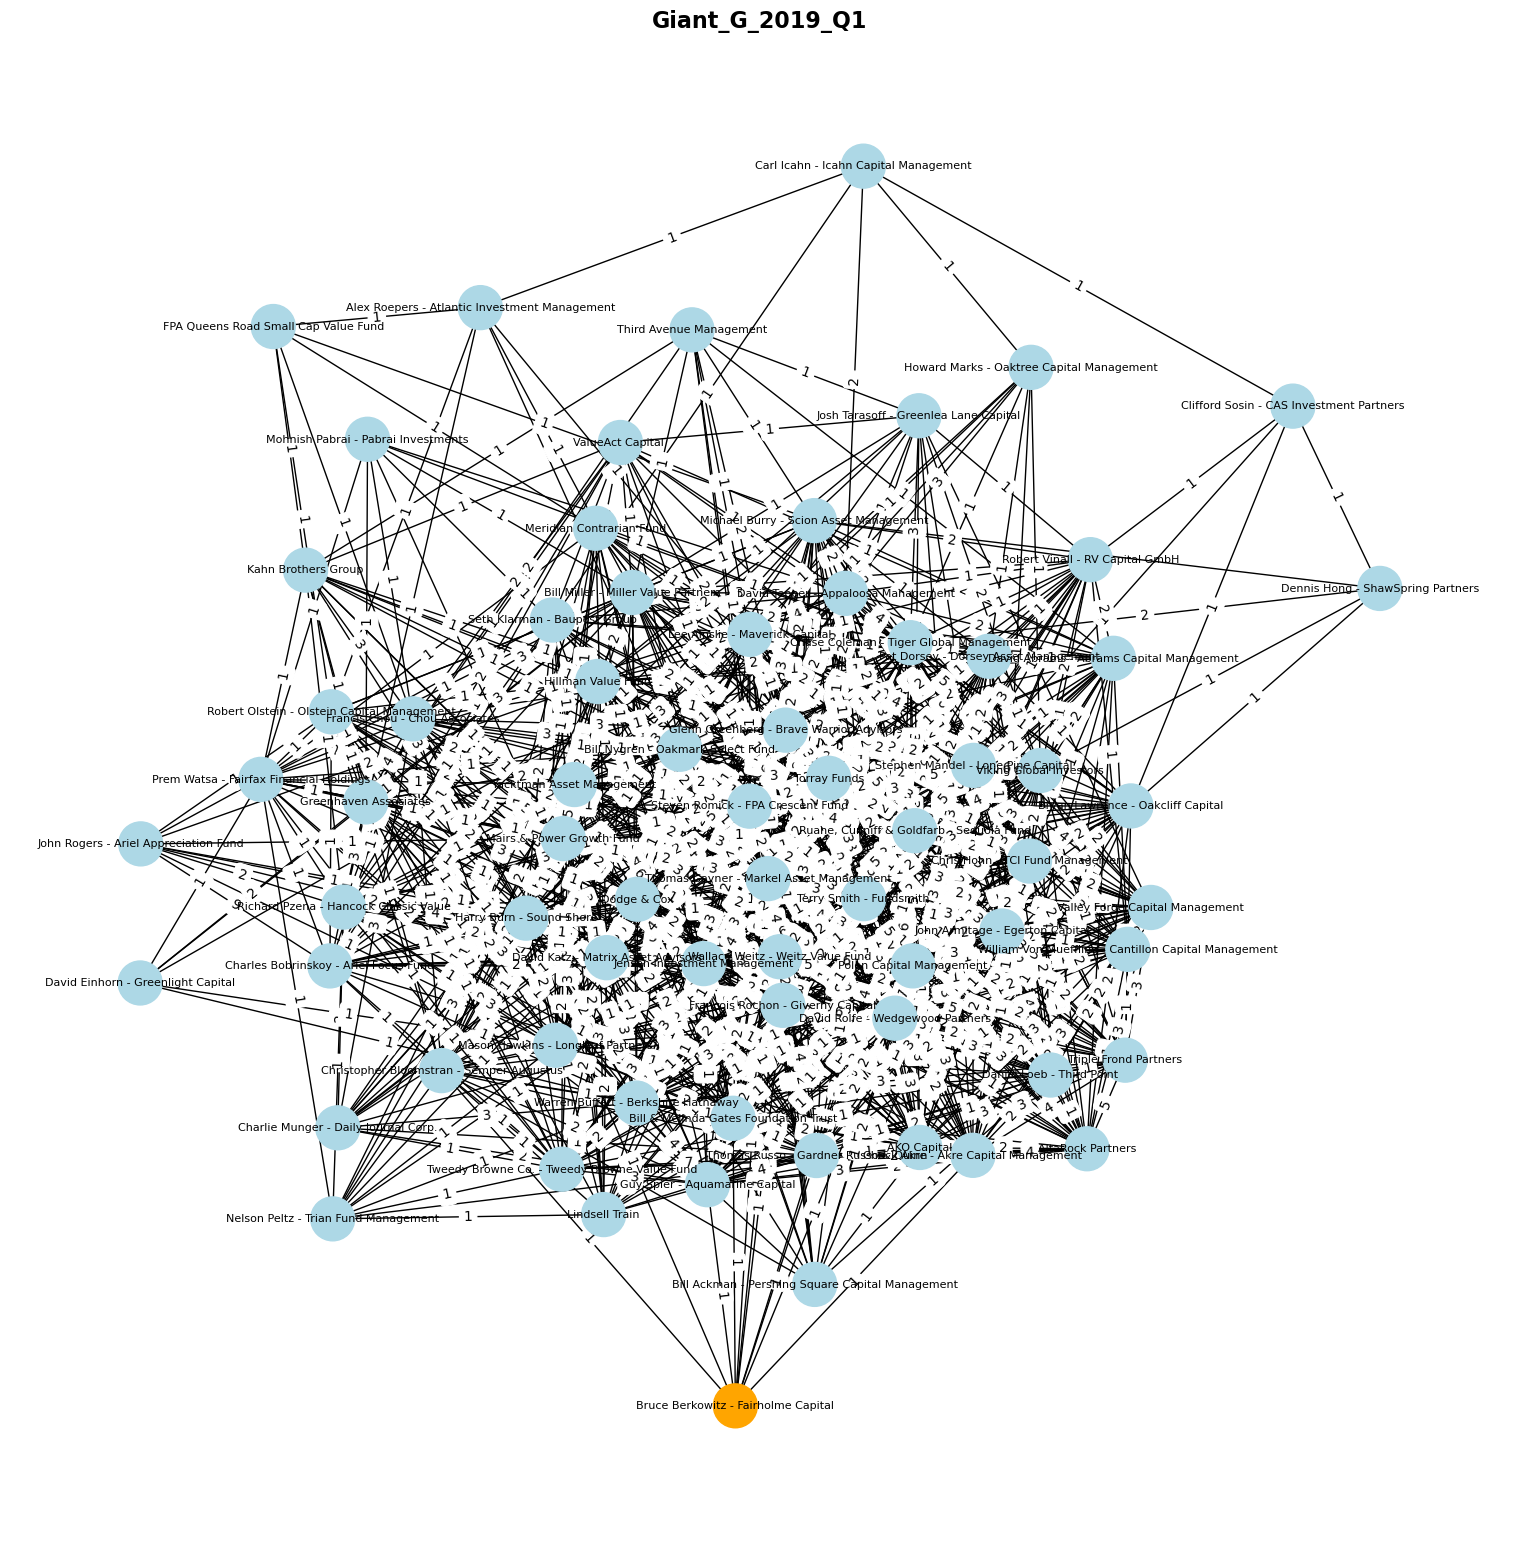

In [9]:
Giant_G_2019_Q1 = extract_giant_component_from_graph(G_2019_Q1)

draw_graphviz(Giant_G_2019_Q1, 'Giant_G_2019_Q1', 'lightblue')

**Task 1.2 (3 marks)** <br>
Obtain the ego-network of 'Bruce Berkowitz - Fairholme Capital' and plot it.

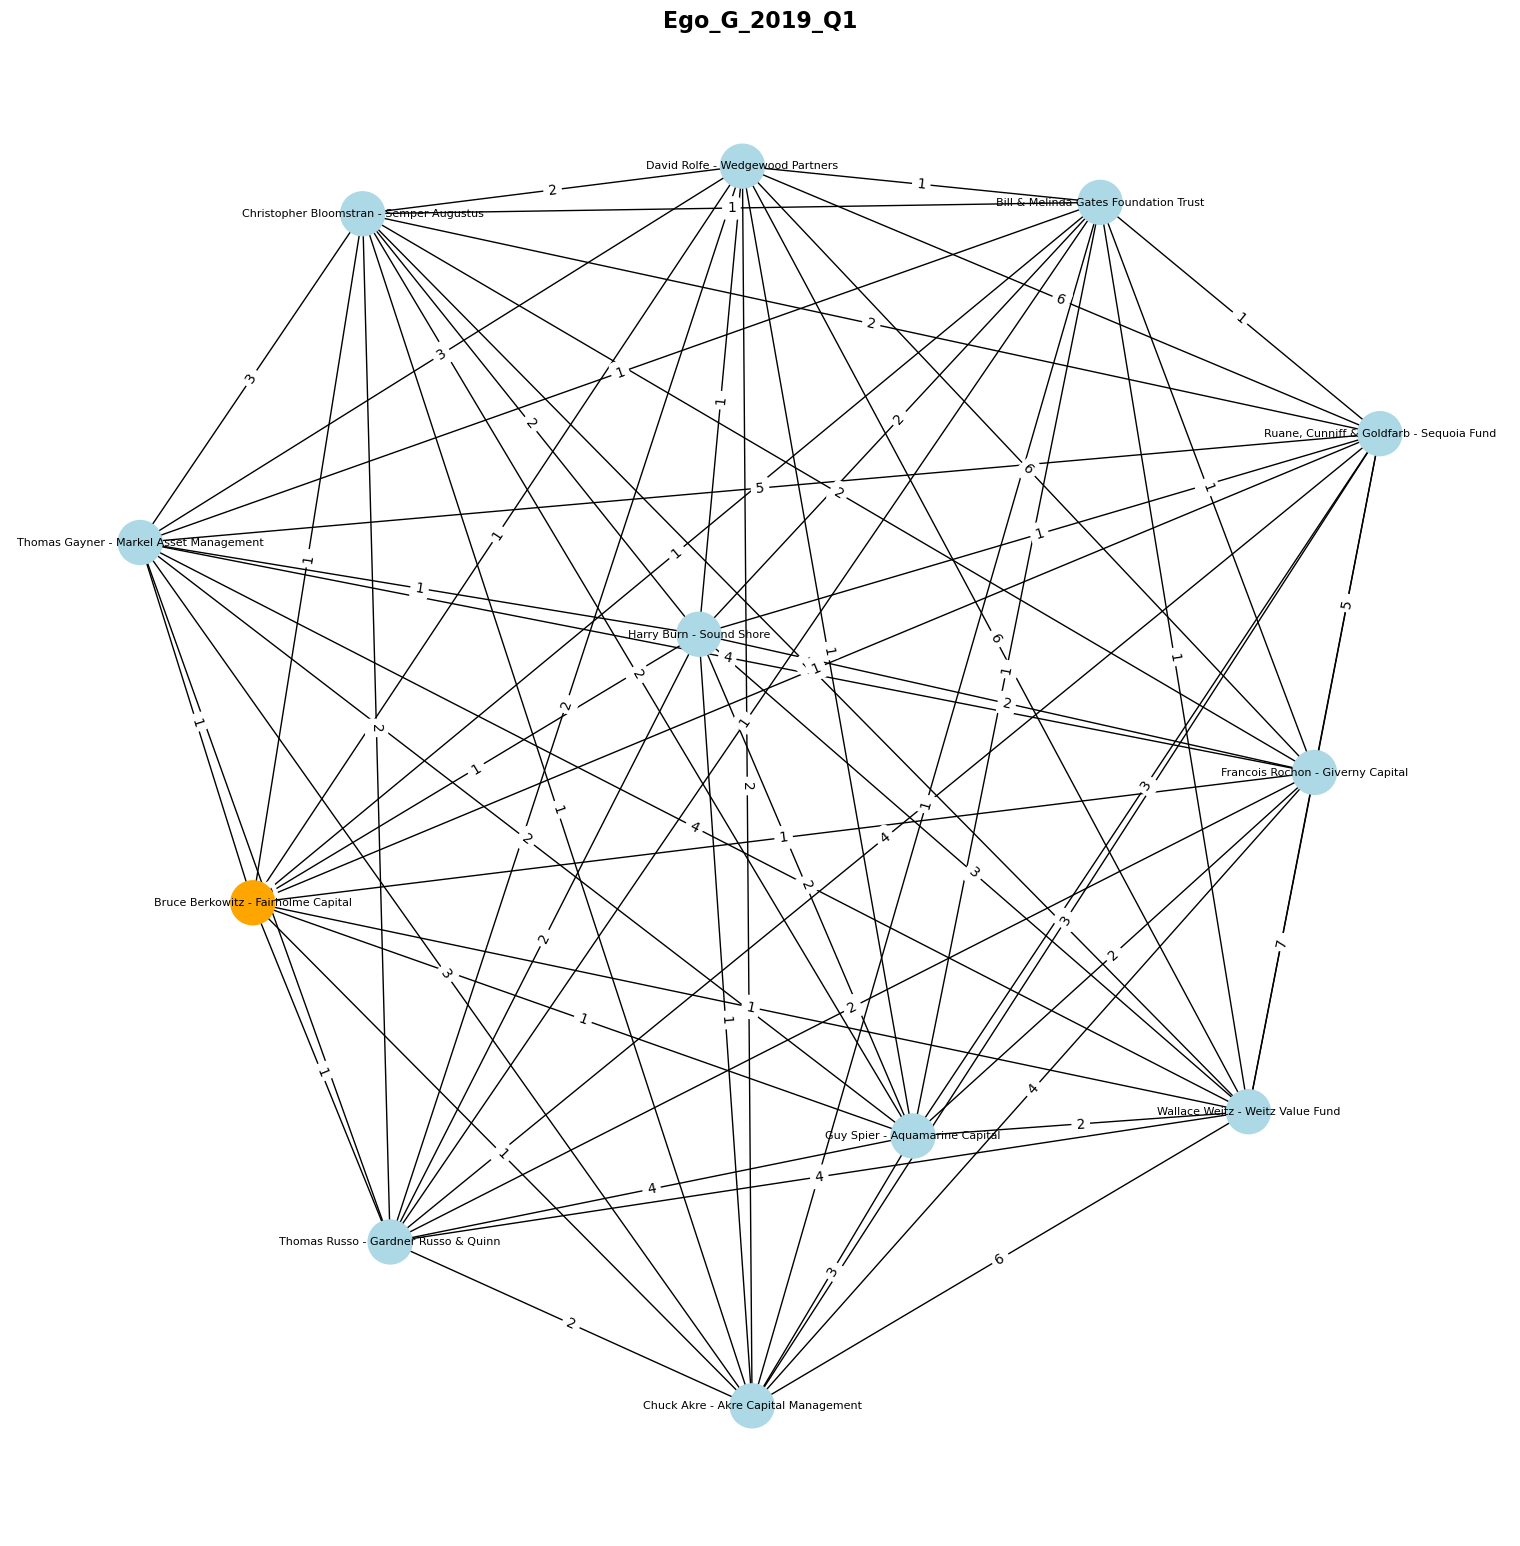

In [10]:
# CODE HERE
Ego_G_2019_Q1 = build_ego_network_for_node(G_2019_Q1, 'Bruce Berkowitz - Fairholme Capital')

draw_graphviz(Ego_G_2019_Q1, 'Ego_G_2019_Q1', 'lightblue', 'fdp')

#### Part 2: Basic Network Analysis

**Task 2.1 (15 marks)** <br>
Now that you know how to build the network for a single quarter and get its largest connected component, repeat the procedure for all the other quarters. For both the whole network and the ego-network, produce a table with the summary statistics (i.e. mean, max, min, and standard deviation) of the following network quantities:

- Number of nodes
- Number of links
- Density
- Average clustering coefficient
- Average degrees
- Average strength
- Assortativity

If you need to make any assumption or decision regarding the metric to use to compute any of these quantities, clearly motivate it.

#### Assumption
1. As Density and Clustering are potentially to be 1 (max value) in ego network, which resulting NaN in Degree Assortativity, I add Strength Assortativity and Clustering Assortativity to deepen the analysis
2. I use Whole Network instead of Giant Component as the comparator for Ego Network as I want to put local vs global analysis, where global is represented by Whole Network while local is represented by Ego Network. Also, I think Network Statistic Summary is well represented by Whole Network instead of only Giant Component
3. I calculate summary statistics by combining the data from multiple quarters. I calculate the summary statistics for both Whole Network and Ego Network. I also add splitted analysis pre-covid (Q1 2019 - Q4 2019) and post-covid (Q1 2020 - Q2 2023). This to see pattern that might emerge from these 2 point of times. So, there will be 6 summaries : Whole Network All-Time, Whole Network Pre-Cov, Whole Network Post-Cov, Ego Network All-Time, Ego Network Pre-Cov, Ego Network Post-Cov

In [88]:
#CODE HERE
summaryWholeAllTime = {}
summaryEgoAllTime = {}

summaryWholePreCovid = {}
summaryEgoPreCovid = {}

summaryWholePostCovid = {}
summaryEgoPostCovid = {}

In [89]:
# 2019_Q1 Whole
add_strength_to_nodes(G_2019_Q1)
add_clustering_to_nodes(G_2019_Q1)

ns_G_2019_Q1 = get_network_summary_for_graph(G_2019_Q1)
summaryWholeAllTime["G_2019_Q1"] = ns_G_2019_Q1
summaryWholePreCovid["G_2019_Q1"] = ns_G_2019_Q1
print(ns_G_2019_Q1)

# 2019_Q1 Ego
add_strength_to_nodes(Ego_G_2019_Q1)
add_clustering_to_nodes(Ego_G_2019_Q1)

ns_Ego_G_2019_Q1 = get_network_summary_for_graph(Ego_G_2019_Q1)
summaryEgoAllTime["G_2019_Q1"] = ns_Ego_G_2019_Q1
summaryEgoPreCovid["G_2019_Q1"] = ns_Ego_G_2019_Q1
print(ns_Ego_G_2019_Q1)

{'nodesCount': 71, 'edgesCount': 1070, 'density': 0.4305835010060362, 'averageClustering': 0.645886845865244, 'averageDegrees': 30.140845070422536, 'averageStrength': 57.66197183098591, 'degreeAssortativity': 0.05824723419739148, 'strengthAssortativity': 0.03938655914746915, 'clusteringAssortativity': 0.15722849551704976}
{'nodesCount': 12, 'edgesCount': 66, 'density': 1.0, 'averageClustering': 1.0, 'averageDegrees': 11.0, 'averageStrength': 26.333333333333332, 'degreeAssortativity': nan, 'strengthAssortativity': -0.09090909090908841, 'clusteringAssortativity': nan}


/Users/teofebano/anaconda3/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [90]:
df_2019_Q2 = pd.read_excel('./Assignment_Data/2019_Q2.xlsx', header=None)

G_2019_Q2 = nx.Graph()

# 2019_Q2 Whole
populate_graph(G_2019_Q2, df_2019_Q2)

# 2019_Q2 Giant
Giant_G_2019_Q2 = extract_giant_component_from_graph(G_2019_Q2)

# 2019_Q2 Ego
Ego_G_2019_Q2 = build_ego_network_for_node(G_2019_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2019_Q2)
add_clustering_to_nodes(G_2019_Q2)
add_strength_to_nodes(Ego_G_2019_Q2)
add_clustering_to_nodes(Ego_G_2019_Q2)

# Calculate Summary
ns_G_2019_Q2 = get_network_summary_for_graph(G_2019_Q2)
ns_Ego_G_2019_Q2 = get_network_summary_for_graph(Ego_G_2019_Q2)

summaryWholeAllTime["G_2019_Q2"] = ns_G_2019_Q2
summaryEgoAllTime["G_2019_Q2"] = ns_Ego_G_2019_Q2

summaryWholePreCovid["G_2019_Q2"] = ns_G_2019_Q2
summaryEgoPreCovid["G_2019_Q2"] = ns_Ego_G_2019_Q2

print(ns_G_2019_Q2)
print(ns_Ego_G_2019_Q2)

{'nodesCount': 73, 'edgesCount': 1086, 'density': 0.4132420091324201, 'averageClustering': 0.6478984359157354, 'averageDegrees': 29.753424657534246, 'averageStrength': 56.32876712328767, 'degreeAssortativity': 0.02314822663497052, 'strengthAssortativity': -0.0027106339552464, 'clusteringAssortativity': 0.0760815828016848}
{'nodesCount': 14, 'edgesCount': 91, 'density': 1.0, 'averageClustering': 1.0, 'averageDegrees': 13.0, 'averageStrength': 31.428571428571427, 'degreeAssortativity': nan, 'strengthAssortativity': -0.0769230769230754, 'clusteringAssortativity': nan}


/Users/teofebano/anaconda3/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [91]:
df_2019_Q3 = pd.read_excel('./Assignment_Data/2019_Q3.xlsx', header=None)

G_2019_Q3 = nx.Graph()

# 2019_Q3 Whole
populate_graph(G_2019_Q3, df_2019_Q3)

# 2019_Q3 Giant
Giant_2019_Q3 = extract_giant_component_from_graph(G_2019_Q3)

# 2019_Q3 Ego
Ego_G_2019_Q3 = build_ego_network_for_node(G_2019_Q3, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2019_Q3)
add_clustering_to_nodes(G_2019_Q3)
add_strength_to_nodes(Ego_G_2019_Q3)
add_clustering_to_nodes(Ego_G_2019_Q3)

# Calculate Summary
ns_G_2019_Q3 = get_network_summary_for_graph(G_2019_Q3)
ns_Ego_G_2019_Q3 = get_network_summary_for_graph(Ego_G_2019_Q3)

summaryWholeAllTime["G_2019_Q3"] = ns_G_2019_Q3
summaryEgoAllTime["G_2019_Q3"] = ns_Ego_G_2019_Q3

summaryWholePreCovid["G_2019_Q3"] = ns_G_2019_Q3
summaryEgoPreCovid["G_2019_Q3"] = ns_Ego_G_2019_Q3

print(ns_G_2019_Q3)
print(ns_Ego_G_2019_Q3)

{'nodesCount': 74, 'edgesCount': 1064, 'density': 0.39392817475009256, 'averageClustering': 0.6354141765282975, 'averageDegrees': 28.756756756756758, 'averageStrength': 53.351351351351354, 'degreeAssortativity': 0.035976024481126086, 'strengthAssortativity': 0.027168428834173655, 'clusteringAssortativity': 0.08922959576842959}
{'nodesCount': 16, 'edgesCount': 108, 'density': 0.9, 'averageClustering': 0.9540293040293042, 'averageDegrees': 13.5, 'averageStrength': 30.125, 'degreeAssortativity': -0.13297872340425956, 'strengthAssortativity': -0.08376129734534635, 'clusteringAssortativity': -0.11336333751787872}


In [92]:
df_2019_Q4 = pd.read_excel('./Assignment_Data/2019_Q4.xlsx', header=None)

G_2019_Q4 = nx.Graph()

# 2019_Q4 Whole
populate_graph(G_2019_Q4, df_2019_Q4)

# 2019_Q4 Giant
Giant_2019_Q4 = extract_giant_component_from_graph(G_2019_Q4)

# 2019_Q4 Ego
Ego_G_2019_Q4 = build_ego_network_for_node(G_2019_Q4, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2019_Q4)
add_clustering_to_nodes(G_2019_Q4)
add_strength_to_nodes(Ego_G_2019_Q4)
add_clustering_to_nodes(Ego_G_2019_Q4)

# Calculate Summary
ns_G_2019_Q4 = get_network_summary_for_graph(G_2019_Q4)
ns_Ego_G_2019_Q4 = get_network_summary_for_graph(Ego_G_2019_Q4)

summaryWholeAllTime["G_2019_Q4"] = ns_G_2019_Q4
summaryEgoAllTime["G_2019_Q4"] = ns_Ego_G_2019_Q4

summaryWholePreCovid["G_2019_Q4"] = ns_G_2019_Q4
summaryEgoPreCovid["G_2019_Q4"] = ns_Ego_G_2019_Q4

print(ns_G_2019_Q4)
print(ns_Ego_G_2019_Q4)

{'nodesCount': 77, 'edgesCount': 1187, 'density': 0.40567327409432674, 'averageClustering': 0.6498732353192321, 'averageDegrees': 30.83116883116883, 'averageStrength': 56.64935064935065, 'degreeAssortativity': 0.027386367027512293, 'strengthAssortativity': 0.010833952147910726, 'clusteringAssortativity': 0.04360350786368307}
{'nodesCount': 15, 'edgesCount': 105, 'density': 1.0, 'averageClustering': 1.0, 'averageDegrees': 14.0, 'averageStrength': 34.13333333333333, 'degreeAssortativity': nan, 'strengthAssortativity': -0.0714285714285706, 'clusteringAssortativity': nan}


/Users/teofebano/anaconda3/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


In [93]:
df_2020_Q1 = pd.read_excel('./Assignment_Data/2020_Q1.xlsx', header=None)

G_2020_Q1 = nx.Graph()

# 2020_Q1 Whole
populate_graph(G_2020_Q1, df_2020_Q1)

# 2020_Q1 Giant
Giant_2020_Q1 = extract_giant_component_from_graph(G_2020_Q1)

# 2020_Q1 Ego
Ego_G_2020_Q1 = build_ego_network_for_node(G_2020_Q1, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2020_Q1)
add_clustering_to_nodes(G_2020_Q1)
add_strength_to_nodes(Ego_G_2020_Q1)
add_clustering_to_nodes(Ego_G_2020_Q1)

# Calculate Summary
ns_G_2020_Q1 = get_network_summary_for_graph(G_2020_Q1)
ns_Ego_G_2020_Q1 = get_network_summary_for_graph(Ego_G_2020_Q1)

summaryWholeAllTime["G_2020_Q1"] = ns_G_2020_Q1
summaryEgoAllTime["G_2020_Q1"] = ns_Ego_G_2020_Q1

summaryWholePostCovid["G_2020_Q1"] = ns_G_2020_Q1
summaryEgoPostCovid["G_2020_Q1"] = ns_Ego_G_2020_Q1

print(ns_G_2020_Q1)
print(ns_Ego_G_2020_Q1)

{'nodesCount': 77, 'edgesCount': 1378, 'density': 0.4709501025290499, 'averageClustering': 0.6946550505374036, 'averageDegrees': 35.79220779220779, 'averageStrength': 71.01298701298701, 'degreeAssortativity': 0.040650982494845396, 'strengthAssortativity': 0.019799657469847447, 'clusteringAssortativity': 0.12907896862899645}
{'nodesCount': 18, 'edgesCount': 129, 'density': 0.8431372549019608, 'averageClustering': 0.8959619175305451, 'averageDegrees': 14.333333333333334, 'averageStrength': 35.111111111111114, 'degreeAssortativity': -0.17629179331308698, 'strengthAssortativity': -0.04067850297573491, 'clusteringAssortativity': 0.1457184843451444}


In [94]:
df_2020_Q2 = pd.read_excel('./Assignment_Data/2020_Q2.xlsx', header=None)

G_2020_Q2 = nx.Graph()

# 2020_Q2 Whole
populate_graph(G_2020_Q2, df_2020_Q2)

# 2020_Q2 Giant
Giant_2020_Q2 = extract_giant_component_from_graph(G_2020_Q2)

# 2020_Q2 Ego
Ego_G_2020_Q2 = build_ego_network_for_node(G_2020_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2020_Q2)
add_clustering_to_nodes(G_2020_Q2)
add_strength_to_nodes(Ego_G_2020_Q2)
add_clustering_to_nodes(Ego_G_2020_Q2)

# Calculate Summary
ns_G_2020_Q2 = get_network_summary_for_graph(G_2020_Q2)
ns_Ego_G_2020_Q2 = get_network_summary_for_graph(Ego_G_2020_Q2)

summaryWholeAllTime["G_2020_Q2"] = ns_G_2020_Q2
summaryEgoAllTime["G_2020_Q2"] = ns_Ego_G_2020_Q2

summaryWholePostCovid["G_2020_Q2"] = ns_G_2020_Q2
summaryEgoPostCovid["G_2020_Q2"] = ns_Ego_G_2020_Q2


print(ns_G_2020_Q2)
print(ns_Ego_G_2020_Q2)

{'nodesCount': 77, 'edgesCount': 1360, 'density': 0.46479835953520166, 'averageClustering': 0.7174999812017033, 'averageDegrees': 35.324675324675326, 'averageStrength': 72.31168831168831, 'degreeAssortativity': 0.046580943451144385, 'strengthAssortativity': 0.013681388971622523, 'clusteringAssortativity': 0.07852436822515907}
{'nodesCount': 21, 'edgesCount': 173, 'density': 0.8238095238095238, 'averageClustering': 0.9271658370950719, 'averageDegrees': 16.476190476190474, 'averageStrength': 42.0, 'degreeAssortativity': -0.14493554582257986, 'strengthAssortativity': -0.04348139763995684, 'clusteringAssortativity': -0.15435927830808555}


In [95]:
df_2020_Q3 = pd.read_excel('./Assignment_Data/2020_Q3.xlsx', header=None)

G_2020_Q3 = nx.Graph()

# 2020_Q3 Whole
populate_graph(G_2020_Q3, df_2020_Q3)

# 2020_Q3 Giant
Giant_2020_Q3 = extract_giant_component_from_graph(G_2020_Q3)

# 2020_Q3 Ego
Ego_G_2020_Q3 = build_ego_network_for_node(G_2020_Q3, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2020_Q3)
add_clustering_to_nodes(G_2020_Q3)
add_strength_to_nodes(Ego_G_2020_Q3)
add_clustering_to_nodes(Ego_G_2020_Q3)

# Calculate Summary
ns_G_2020_Q3 = get_network_summary_for_graph(G_2020_Q3)
ns_Ego_G_2020_Q3 = get_network_summary_for_graph(Ego_G_2020_Q3)

summaryWholeAllTime["G_2020_Q3"] = ns_G_2020_Q3
summaryEgoAllTime["G_2020_Q3"] = ns_Ego_G_2020_Q3

summaryWholePostCovid["G_2020_Q3"] = ns_G_2020_Q3
summaryEgoPostCovid["G_2020_Q3"] = ns_Ego_G_2020_Q3

print(ns_G_2020_Q3)
print(ns_Ego_G_2020_Q3)

{'nodesCount': 77, 'edgesCount': 1383, 'density': 0.47265892002734106, 'averageClustering': 0.7117226587222614, 'averageDegrees': 35.922077922077925, 'averageStrength': 73.66233766233766, 'degreeAssortativity': 0.0373584468214413, 'strengthAssortativity': 0.022120311843100426, 'clusteringAssortativity': 0.1245004550326284}
{'nodesCount': 29, 'edgesCount': 309, 'density': 0.7610837438423645, 'averageClustering': 0.837962953255307, 'averageDegrees': 21.310344827586206, 'averageStrength': 50.689655172413794, 'degreeAssortativity': -0.15992842023346782, 'strengthAssortativity': -0.06039381946912277, 'clusteringAssortativity': 0.004661714522187256}


In [96]:
df_2020_Q4 = pd.read_excel('./Assignment_Data/2020_Q4.xlsx', header=None)

G_2020_Q4 = nx.Graph()

# 2020_Q4 Whole
populate_graph(G_2020_Q4, df_2020_Q4)

# 2020_Q4 Giant
Giant_2020_Q4 = extract_giant_component_from_graph(G_2020_Q4)

# 2020_Q4 Ego
Ego_G_2020_Q4 = build_ego_network_for_node(G_2020_Q4, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2020_Q4)
add_clustering_to_nodes(G_2020_Q4)
add_strength_to_nodes(Ego_G_2020_Q4)
add_clustering_to_nodes(Ego_G_2020_Q4)

# Calculate Summary
ns_G_2020_Q4 = get_network_summary_for_graph(G_2020_Q4)
ns_Ego_G_2020_Q4 = get_network_summary_for_graph(Ego_G_2020_Q4)

summaryWholeAllTime["G_2020_Q4"] = ns_G_2020_Q4
summaryEgoAllTime["G_2020_Q4"] = ns_Ego_G_2020_Q4

summaryWholePostCovid["G_2020_Q4"] = ns_G_2020_Q4
summaryEgoPostCovid["G_2020_Q4"] = ns_Ego_G_2020_Q4

print(ns_G_2020_Q4)
print(ns_Ego_G_2020_Q4)

{'nodesCount': 77, 'edgesCount': 1367, 'density': 0.4671907040328093, 'averageClustering': 0.7101253780503647, 'averageDegrees': 35.506493506493506, 'averageStrength': 72.23376623376623, 'degreeAssortativity': 0.024729357774428796, 'strengthAssortativity': 0.012835892627863547, 'clusteringAssortativity': 0.12849398620617505}
{'nodesCount': 33, 'edgesCount': 378, 'density': 0.7159090909090909, 'averageClustering': 0.8250255216153309, 'averageDegrees': 22.90909090909091, 'averageStrength': 50.60606060606061, 'degreeAssortativity': -0.09782962889988452, 'strengthAssortativity': -0.04357404141742575, 'clusteringAssortativity': -0.08121026268616477}


In [97]:
df_2021_Q1 = pd.read_excel('./Assignment_Data/2021_Q1.xlsx', header=None)

G_2021_Q1 = nx.Graph()

# 2021_Q1 Whole
populate_graph(G_2021_Q1, df_2021_Q1)

# 2021_Q1 Giant
Giant_2021_Q1 = extract_giant_component_from_graph(G_2021_Q1)

# 2021_Q1 Ego
Ego_G_2021_Q1 = build_ego_network_for_node(G_2021_Q1, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2021_Q1)
add_clustering_to_nodes(G_2021_Q1)
add_strength_to_nodes(Ego_G_2021_Q1)
add_clustering_to_nodes(Ego_G_2021_Q1)

# Calculate Summary
ns_G_2021_Q1 = get_network_summary_for_graph(G_2021_Q1)
ns_Ego_G_2021_Q1 = get_network_summary_for_graph(Ego_G_2021_Q1)

summaryWholeAllTime["G_2021_Q1"] = ns_G_2021_Q1
summaryEgoAllTime["G_2021_Q1"] = ns_Ego_G_2021_Q1

summaryWholePostCovid["G_2021_Q1"] = ns_G_2021_Q1
summaryEgoPostCovid["G_2021_Q1"] = ns_Ego_G_2021_Q1

print(ns_G_2021_Q1)
print(ns_Ego_G_2021_Q1)

{'nodesCount': 77, 'edgesCount': 1361, 'density': 0.46514012303485985, 'averageClustering': 0.7116713648082954, 'averageDegrees': 35.35064935064935, 'averageStrength': 69.92207792207792, 'degreeAssortativity': 0.03802365970011102, 'strengthAssortativity': 0.03196664664602411, 'clusteringAssortativity': 0.16828708835591308}
{'nodesCount': 30, 'edgesCount': 292, 'density': 0.671264367816092, 'averageClustering': 0.8024580749321281, 'averageDegrees': 19.466666666666665, 'averageStrength': 40.06666666666667, 'degreeAssortativity': -0.06271180510432096, 'strengthAssortativity': 0.00454457145302526, 'clusteringAssortativity': -0.007381003329383153}


In [98]:
df_2021_Q2 = pd.read_excel('./Assignment_Data/2021_Q2.xlsx', header=None)

G_2021_Q2 = nx.Graph()

# 2021_Q2 Whole
populate_graph(G_2021_Q2, df_2021_Q2)

# 2021_Q2 Giant
Giant_2021_Q2 = extract_giant_component_from_graph(G_2021_Q2)

# 2021_Q2 Ego
Ego_G_2021_Q2 = build_ego_network_for_node(G_2021_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2021_Q2)
add_clustering_to_nodes(G_2021_Q2)
add_strength_to_nodes(Ego_G_2021_Q2)
add_clustering_to_nodes(Ego_G_2021_Q2)

# Calculate Summary
ns_G_2021_Q2 = get_network_summary_for_graph(G_2021_Q2)
ns_Ego_G_2021_Q2 = get_network_summary_for_graph(Ego_G_2021_Q2)

summaryWholeAllTime["G_2021_Q2"] = ns_G_2021_Q2
summaryEgoAllTime["G_2021_Q2"] = ns_Ego_G_2021_Q2

summaryWholePostCovid["G_2021_Q2"] = ns_G_2021_Q2
summaryEgoPostCovid["G_2021_Q2"] = ns_Ego_G_2021_Q2

print(ns_G_2021_Q2)
print(ns_Ego_G_2021_Q2)

{'nodesCount': 77, 'edgesCount': 1350, 'density': 0.4613807245386193, 'averageClustering': 0.7174067076387718, 'averageDegrees': 35.064935064935064, 'averageStrength': 70.28571428571429, 'degreeAssortativity': 0.06301881634331377, 'strengthAssortativity': 0.06155956223727997, 'clusteringAssortativity': 0.1955901316102713}
{'nodesCount': 36, 'edgesCount': 412, 'density': 0.653968253968254, 'averageClustering': 0.7992399567048245, 'averageDegrees': 22.88888888888889, 'averageStrength': 45.94444444444444, 'degreeAssortativity': -0.11104623200486073, 'strengthAssortativity': -0.04151558679467851, 'clusteringAssortativity': -0.0752681552457376}


In [99]:
df_2021_Q3 = pd.read_excel('./Assignment_Data/2021_Q3.xlsx', header=None)

G_2021_Q3 = nx.Graph()

# 2021_Q3 Whole
populate_graph(G_2021_Q3, df_2021_Q3)

# 2021_Q3 Giant
Giant_2021_Q3 = extract_giant_component_from_graph(G_2021_Q3)

# 2021_Q3 Ego
Ego_G_2021_Q3 = build_ego_network_for_node(G_2021_Q3, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2021_Q3)
add_clustering_to_nodes(G_2021_Q3)
add_strength_to_nodes(Ego_G_2021_Q3)
add_clustering_to_nodes(Ego_G_2021_Q3)

# Calculate Summary
ns_G_2021_Q3 = get_network_summary_for_graph(G_2021_Q3)
ns_Ego_G_2021_Q3 = get_network_summary_for_graph(Ego_G_2021_Q3)

summaryWholeAllTime["G_2021_Q3"] = ns_G_2021_Q3
summaryEgoAllTime["G_2021_Q3"] = ns_Ego_G_2021_Q3

summaryWholePostCovid["G_2021_Q3"] = ns_G_2021_Q3
summaryEgoPostCovid["G_2021_Q3"] = ns_Ego_G_2021_Q3

print(ns_G_2021_Q3)
print(ns_Ego_G_2021_Q3)

{'nodesCount': 77, 'edgesCount': 1337, 'density': 0.4569377990430622, 'averageClustering': 0.6931266187850186, 'averageDegrees': 34.72727272727273, 'averageStrength': 70.07792207792208, 'degreeAssortativity': 0.10346332880874505, 'strengthAssortativity': 0.10473974563235923, 'clusteringAssortativity': 0.24610231641648103}
{'nodesCount': 33, 'edgesCount': 358, 'density': 0.678030303030303, 'averageClustering': 0.8209192468283968, 'averageDegrees': 21.696969696969695, 'averageStrength': 43.57575757575758, 'degreeAssortativity': -0.09204175887892893, 'strengthAssortativity': -0.04394458283967644, 'clusteringAssortativity': -0.09179508927759494}


In [100]:
df_2021_Q4 = pd.read_excel('./Assignment_Data/2021_Q4.xlsx', header=None)

G_2021_Q4 = nx.Graph()

# 2021_Q4 Whole
populate_graph(G_2021_Q4, df_2021_Q4)

# 2021_Q4 Giant
Giant_2021_Q4 = extract_giant_component_from_graph(G_2021_Q4)

# 2021_Q4 Ego
Ego_G_2021_Q4 = build_ego_network_for_node(G_2021_Q4, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2021_Q4)
add_clustering_to_nodes(G_2021_Q4)
add_strength_to_nodes(Ego_G_2021_Q4)
add_clustering_to_nodes(Ego_G_2021_Q4)

# Calculate Summary
ns_G_2021_Q4 = get_network_summary_for_graph(G_2021_Q4)
ns_Ego_G_2021_Q4 = get_network_summary_for_graph(Ego_G_2021_Q4)

summaryWholeAllTime["G_2021_Q4"] = ns_G_2021_Q4
summaryEgoAllTime["G_2021_Q4"] = ns_Ego_G_2021_Q4

summaryWholePostCovid["G_2021_Q4"] = ns_G_2021_Q4
summaryEgoPostCovid["G_2021_Q4"] = ns_Ego_G_2021_Q4

print(ns_G_2021_Q4)
print(ns_Ego_G_2021_Q4)

{'nodesCount': 77, 'edgesCount': 1330, 'density': 0.45454545454545453, 'averageClustering': 0.6929233214586019, 'averageDegrees': 34.54545454545455, 'averageStrength': 69.01298701298701, 'degreeAssortativity': 0.07341050603541131, 'strengthAssortativity': 0.10645083126684621, 'clusteringAssortativity': 0.20102821965200032}
{'nodesCount': 38, 'edgesCount': 424, 'density': 0.6031294452347084, 'averageClustering': 0.7654888506858858, 'averageDegrees': 22.31578947368421, 'averageStrength': 42.473684210526315, 'degreeAssortativity': -0.07973022797958432, 'strengthAssortativity': 0.003081470464059353, 'clusteringAssortativity': -0.061114587200616396}


In [101]:
df_2022_Q1 = pd.read_excel('./Assignment_Data/2022_Q1.xlsx', header=None)

G_2022_Q1 = nx.Graph()

# 2022_Q1 Whole
populate_graph(G_2022_Q1, df_2022_Q1)

# 2022_Q1 Giant
Giant_2022_Q1 = extract_giant_component_from_graph(G_2022_Q1)

# 2022_Q1 Ego
Ego_G_2022_Q1 = build_ego_network_for_node(G_2022_Q1, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2022_Q1)
add_clustering_to_nodes(G_2022_Q1)
add_strength_to_nodes(Ego_G_2022_Q1)
add_clustering_to_nodes(Ego_G_2022_Q1)

# Calculate Summary
ns_G_2022_Q1 = get_network_summary_for_graph(G_2022_Q1)
ns_Ego_G_2022_Q1 = get_network_summary_for_graph(Ego_G_2022_Q1)

summaryWholeAllTime["G_2022_Q1"] = ns_G_2022_Q1
summaryEgoAllTime["G_2022_Q1"] = ns_Ego_G_2022_Q1

summaryWholePostCovid["G_2022_Q1"] = ns_G_2022_Q1
summaryEgoPostCovid["G_2022_Q1"] = ns_Ego_G_2022_Q1

print(ns_G_2022_Q1)
print(ns_Ego_G_2022_Q1)

{'nodesCount': 77, 'edgesCount': 1346, 'density': 0.4600136705399863, 'averageClustering': 0.7054633446143871, 'averageDegrees': 34.96103896103896, 'averageStrength': 67.63636363636364, 'degreeAssortativity': 0.06436408868283702, 'strengthAssortativity': 0.08745441594786908, 'clusteringAssortativity': 0.16944272388693746}
{'nodesCount': 37, 'edgesCount': 438, 'density': 0.6576576576576577, 'averageClustering': 0.7557137803741475, 'averageDegrees': 23.675675675675677, 'averageStrength': 43.08108108108108, 'degreeAssortativity': -0.03716894868125044, 'strengthAssortativity': -0.007975790694123923, 'clusteringAssortativity': 0.049018336547314065}


In [102]:
df_2022_Q2 = pd.read_excel('./Assignment_Data/2022_Q2.xlsx', header=None)

G_2022_Q2 = nx.Graph()

# 2022_Q2 Whole
populate_graph(G_2022_Q2, df_2022_Q2)

# 2022_Q2 Giant
Giant_2022_Q2 = extract_giant_component_from_graph(G_2022_Q2)

# 2022_Q2 Ego
Ego_G_2022_Q2 = build_ego_network_for_node(G_2022_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2022_Q2)
add_clustering_to_nodes(G_2022_Q2)
add_strength_to_nodes(Ego_G_2022_Q2)
add_clustering_to_nodes(Ego_G_2022_Q2)

# Calculate Summary
ns_G_2022_Q2 = get_network_summary_for_graph(G_2022_Q2)
ns_Ego_G_2022_Q2 = get_network_summary_for_graph(Ego_G_2022_Q2)

summaryWholeAllTime["G_2022_Q2"] = ns_G_2022_Q2
summaryEgoAllTime["G_2022_Q2"] = ns_Ego_G_2022_Q2

summaryWholePostCovid["G_2022_Q2"] = ns_G_2022_Q2
summaryEgoPostCovid["G_2022_Q2"] = ns_Ego_G_2022_Q2

print(ns_G_2022_Q2)
print(ns_Ego_G_2022_Q2)

{'nodesCount': 77, 'edgesCount': 1267, 'density': 0.43301435406698563, 'averageClustering': 0.6734168764727639, 'averageDegrees': 32.90909090909091, 'averageStrength': 63.48051948051948, 'degreeAssortativity': 0.08217808104047448, 'strengthAssortativity': 0.09001435263259047, 'clusteringAssortativity': 0.1696621056383594}
{'nodesCount': 37, 'edgesCount': 439, 'density': 0.6591591591591591, 'averageClustering': 0.7689764961298354, 'averageDegrees': 23.72972972972973, 'averageStrength': 44.972972972972975, 'degreeAssortativity': -0.0392446043539185, 'strengthAssortativity': 0.009001607951576621, 'clusteringAssortativity': -0.01028940774495532}


In [103]:
df_2022_Q3 = pd.read_excel('./Assignment_Data/2022_Q3.xlsx', header=None)

G_2022_Q3 = nx.Graph()

# 2022_Q3 Whole
populate_graph(G_2022_Q3, df_2022_Q3)

# 2022_Q3 Giant
Giant_2022_Q3 = extract_giant_component_from_graph(G_2022_Q3)

# 2022_Q3 Ego
Ego_G_2022_Q3 = build_ego_network_for_node(G_2022_Q3, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2022_Q3)
add_clustering_to_nodes(G_2022_Q3)
add_strength_to_nodes(Ego_G_2022_Q3)
add_clustering_to_nodes(Ego_G_2022_Q3)

# Calculate Summary
ns_G_2022_Q3 = get_network_summary_for_graph(G_2022_Q3)
ns_Ego_G_2022_Q3 = get_network_summary_for_graph(Ego_G_2022_Q3)

summaryWholeAllTime["G_2022_Q3"] = ns_G_2022_Q3
summaryEgoAllTime["G_2022_Q3"] = ns_Ego_G_2022_Q3

summaryWholePostCovid["G_2022_Q3"] = ns_G_2022_Q3
summaryEgoPostCovid["G_2022_Q3"] = ns_Ego_G_2022_Q3

print(ns_G_2022_Q3)
print(ns_Ego_G_2022_Q3)

{'nodesCount': 77, 'edgesCount': 1291, 'density': 0.44121667805878334, 'averageClustering': 0.6933472157252142, 'averageDegrees': 33.532467532467535, 'averageStrength': 64.12987012987013, 'degreeAssortativity': 0.0410972432470353, 'strengthAssortativity': 0.05974412636661385, 'clusteringAssortativity': 0.14734802303293912}
{'nodesCount': 36, 'edgesCount': 408, 'density': 0.6476190476190476, 'averageClustering': 0.7899769747401775, 'averageDegrees': 22.666666666666668, 'averageStrength': 42.111111111111114, 'degreeAssortativity': -0.10360491402364623, 'strengthAssortativity': -0.0666685885041137, 'clusteringAssortativity': -0.10332967330833355}


In [104]:
df_2022_Q4 = pd.read_excel('./Assignment_Data/2022_Q4.xlsx', header=None)

G_2022_Q4 = nx.Graph()

# 2022_Q4 Whole
populate_graph(G_2022_Q4, df_2022_Q4)

# 2022_Q4 Giant
Giant_2022_Q4 = extract_giant_component_from_graph(G_2022_Q4)

# 2022_Q4 Ego
Ego_G_2022_Q4 = build_ego_network_for_node(G_2022_Q4, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2022_Q4)
add_clustering_to_nodes(G_2022_Q4)
add_strength_to_nodes(Ego_G_2022_Q4)
add_clustering_to_nodes(Ego_G_2022_Q4)

# Calculate Summary
ns_G_2022_Q4 = get_network_summary_for_graph(G_2022_Q4)
ns_Ego_G_2022_Q4 = get_network_summary_for_graph(Ego_G_2022_Q4)

summaryWholeAllTime["G_2022_Q4"] = ns_G_2022_Q4
summaryEgoAllTime["G_2022_Q4"] = ns_Ego_G_2022_Q4

summaryWholePostCovid["G_2022_Q4"] = ns_G_2022_Q4
summaryEgoPostCovid["G_2022_Q4"] = ns_Ego_G_2022_Q4

print(ns_G_2022_Q4)
print(ns_Ego_G_2022_Q4)

{'nodesCount': 77, 'edgesCount': 1307, 'density': 0.44668489405331513, 'averageClustering': 0.6879740699674023, 'averageDegrees': 33.94805194805195, 'averageStrength': 62.64935064935065, 'degreeAssortativity': 0.043851377276300105, 'strengthAssortativity': 0.08143392513527385, 'clusteringAssortativity': 0.08743410635938624}
{'nodesCount': 35, 'edgesCount': 385, 'density': 0.6470588235294118, 'averageClustering': 0.7754764896095806, 'averageDegrees': 22.0, 'averageStrength': 40.17142857142857, 'degreeAssortativity': -0.12905437274452586, 'strengthAssortativity': -0.05628152498856213, 'clusteringAssortativity': -0.14078106421424563}


In [105]:
df_2023_Q1 = pd.read_excel('./Assignment_Data/2023_Q1.xlsx', header=None)

G_2023_Q1 = nx.Graph()

# 2023_Q1 Whole
populate_graph(G_2023_Q1, df_2023_Q1)

# 2023_Q1 Giant
Giant_2023_Q1 = extract_giant_component_from_graph(G_2023_Q1)

# 2023_Q1 Ego
Ego_G_2023_Q1 = build_ego_network_for_node(G_2023_Q1, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2023_Q1)
add_clustering_to_nodes(G_2023_Q1)
add_strength_to_nodes(Ego_G_2023_Q1)
add_clustering_to_nodes(Ego_G_2023_Q1)

# Calculate Summary
ns_G_2023_Q1 = get_network_summary_for_graph(G_2023_Q1)
ns_Ego_G_2023_Q1 = get_network_summary_for_graph(Ego_G_2023_Q1)

summaryWholeAllTime["G_2023_Q1"] = ns_G_2023_Q1
summaryEgoAllTime["G_2023_Q1"] = ns_Ego_G_2023_Q1

summaryWholePostCovid["G_2023_Q1"] = ns_G_2023_Q1
summaryEgoPostCovid["G_2023_Q1"] = ns_Ego_G_2023_Q1

print(ns_G_2023_Q1)
print(ns_Ego_G_2023_Q1)

{'nodesCount': 77, 'edgesCount': 1377, 'density': 0.47060833902939164, 'averageClustering': 0.7053806414291965, 'averageDegrees': 35.76623376623377, 'averageStrength': 69.11688311688312, 'degreeAssortativity': 0.02006896663592999, 'strengthAssortativity': 0.046820303400710625, 'clusteringAssortativity': 0.0811380152811343}
{'nodesCount': 33, 'edgesCount': 391, 'density': 0.740530303030303, 'averageClustering': 0.827109422605319, 'averageDegrees': 23.696969696969695, 'averageStrength': 48.78787878787879, 'degreeAssortativity': -0.0750361596148143, 'strengthAssortativity': -0.002480663191202101, 'clusteringAssortativity': -0.07177580877892716}


In [106]:
df_2023_Q2 = pd.read_excel('./Assignment_Data/2023_Q2.xlsx', header=None)

G_2023_Q2 = nx.Graph()

# 2023_Q2 Whole
populate_graph(G_2023_Q2, df_2023_Q2)

# 2023_Q2 Giant
Giant_2023_Q2 = extract_giant_component_from_graph(G_2023_Q2)

# 2023_Q2 Ego
Ego_G_2023_Q2 = build_ego_network_for_node(G_2023_Q2, 'Bruce Berkowitz - Fairholme Capital')

# Add Node Attributes
add_strength_to_nodes(G_2023_Q2)
add_clustering_to_nodes(G_2023_Q2)
add_strength_to_nodes(Ego_G_2023_Q2)
add_clustering_to_nodes(Ego_G_2023_Q2)

# Calculate Summary
ns_G_2023_Q2 = get_network_summary_for_graph(G_2023_Q2)
ns_Ego_G_2023_Q2 = get_network_summary_for_graph(Ego_G_2023_Q2)

summaryWholeAllTime["G_2023_Q2"] = ns_G_2023_Q2
summaryEgoAllTime["G_2023_Q2"] = ns_Ego_G_2023_Q2

summaryWholePostCovid["G_2023_Q2"] = ns_G_2023_Q2
summaryEgoPostCovid["G_2023_Q2"] = ns_Ego_G_2023_Q2

print(ns_G_2023_Q2)
print(ns_Ego_G_2023_Q2)

{'nodesCount': 73, 'edgesCount': 1212, 'density': 0.4611872146118721, 'averageClustering': 0.6921901310890488, 'averageDegrees': 33.205479452054796, 'averageStrength': 65.97260273972603, 'degreeAssortativity': 0.08920688107045142, 'strengthAssortativity': 0.07950617503184142, 'clusteringAssortativity': 0.22556092957211407}
{'nodesCount': 27, 'edgesCount': 267, 'density': 0.7606837606837606, 'averageClustering': 0.8636137225782163, 'averageDegrees': 19.77777777777778, 'averageStrength': 43.629629629629626, 'degreeAssortativity': -0.08890634385251109, 'strengthAssortativity': 0.004223670881793692, 'clusteringAssortativity': -0.12786280926508423}


In [107]:
get_statistics_for_graphs(summaryWholeAllTime)

Properties                  max            min          mean        median           SD
------------------  -----------  -------------  ------------  ------------  -----------
# Nodes               77           71             76.0556       77            1.8934
# Edges             1383         1064           1281.83       1333.5        110.555
Density                0.472659     0.393928       0.44832       0.458476     0.0238961
Avg. Clustering        0.7175       0.635414       0.68811       0.693237     0.0264672
Avg. Degrees          35.9221      28.7568        33.6688       34.6364       2.29175
Avg. Strength         73.6623      53.3514        65.8609       68.3247       6.25719
Degree Assort.         0.103463     0.020069       0.0507089     0.0424743    0.024128
Strength Assort.       0.106451    -0.00271063     0.0496003     0.0431034    0.0350988
Clustering Assort.     0.246102     0.0436035      0.139907      0.138213     0.0567477


In [108]:
get_statistics_for_graphs(summaryEgoAllTime)

Properties                   max         min         mean       median           SD
------------------  ------------  ----------  -----------  -----------  -----------
# Nodes              38           12           27.7778      31.5          9.18154
# Edges             439           66          287.389      333.5        137.192
Density               1            0.603129     0.764613     0.72822      0.13324
Avg. Clustering       1            0.755714     0.856062     0.826067     0.0856262
Avg. Degrees         23.7297      11           19.358       21.5037       4.3701
Avg. Strength        50.6897      26.3333      40.8468      42.2924       6.93368
Degree Assort.       -0.0371689   -0.176292    -0.102034    -0.0978296    0.0411359
Strength Assort.      0.00900161  -0.0909091   -0.0393981   -0.0435277    0.0333582
Clustering Assort.    0.145718    -0.154359    -0.0559421   -0.0752682    0.0801662


In [109]:
get_statistics_for_graphs(summaryWholePreCovid)

Properties                   max            min          mean        median           SD
------------------  ------------  -------------  ------------  ------------  -----------
# Nodes               77            71             73.75         73.5         2.5
# Edges             1187          1064           1101.75       1078          57.5869
Density                0.430584      0.393928       0.410857      0.409458    0.0153653
Avg. Clustering        0.649873      0.635414       0.644768      0.646893    0.00644487
Avg. Degrees          30.8312       28.7568        29.8705       29.9471      0.866045
Avg. Strength         57.662        53.3514        55.9979       56.4891      1.85357
Degree Assort.         0.0582472     0.0231482      0.0361895     0.0316812   0.0156435
Strength Assort.       0.0393866    -0.00271063     0.0186696     0.0190012   0.0184385
Clustering Assort.     0.157228      0.0436035      0.0915358     0.0826556   0.0478093


In [110]:
get_statistics_for_graphs(summaryWholePostCovid)

Properties                  max           min          mean        median          SD
------------------  -----------  ------------  ------------  ------------  ----------
# Nodes               77           73            76.7143       77           1.06904
# Edges             1383         1212          1333.29       1348          48.871
Density                0.472659     0.433014      0.459023      0.461284    0.0117056
Avg. Clustering        0.7175       0.673417      0.700493      0.700018    0.0127799
Avg. Degrees          35.9221      32.9091       34.754        35.013       0.993899
Avg. Strength         73.6623      62.6494       68.6789       69.5195      3.45285
Degree Assort.         0.103463     0.020069      0.0548573     0.0452162   0.0249282
Strength Assort.       0.106451     0.0128359     0.0584377     0.0606518   0.0339712
Clustering Assort.     0.246102     0.0785244     0.153728      0.157818    0.0525171


In [117]:
get_statistics_for_graphs(summaryEgoPreCovid)

Properties                  max         min        mean      median  SD
------------------  -----------  ----------  ----------  ----------  --------------------
# Nodes              16          12          14.25       14.5        1.707825127659933
# Edges             108          66          92.5        98          19.157244060668017
Density               1           0.9         0.975       1          0.04999999999999999
Avg. Clustering       1           0.954029    0.988507    1          0.022985347985347904
Avg. Degrees         14          11          12.875      13.25       1.3149778198382918
Avg. Strength        34.1333     26.3333     30.5051     30.7768     3.243711337601662
Degree Assort.       -0.132979   -0.132979   -0.132979   -0.132979   N/A
Strength Assort.     -0.0714286  -0.0909091  -0.0807555  -0.0803422  0.008442142090867088
Clustering Assort.   -0.113363   -0.113363   -0.113363   -0.113363   N/A


In [112]:
get_statistics_for_graphs(summaryEgoPostCovid)

Properties                   max          min         mean       median          SD
------------------  ------------  -----------  -----------  -----------  ----------
# Nodes              38            18           31.6429      33           6.09675
# Edges             439           129          343.071      381.5        97.4817
Density               0.843137      0.603129     0.704503     0.674647    0.0716086
Avg. Clustering       0.927166      0.755714     0.818221     0.811689    0.0502623
Avg. Degrees         23.7297       14.3333      21.2103      22.1579      2.81921
Avg. Strength        50.6897       35.1111      43.8015      43.3284      4.25795
Degree Assort.       -0.0371689    -0.176292    -0.0998236   -0.0949357   0.0417542
Strength Assort.      0.00900161   -0.0666686   -0.0275817   -0.041097    0.0276054
Clustering Assort.    0.145718     -0.154359    -0.0518406   -0.073522    0.0815428


**Task 2.2 (10 marks)** </br>
Discuss why ego networks are useful for exploring the importance of singular nodes. Then, comment on the statistics you computed above and what information they give you about the investment patterns of Bruce Berkowitz - Fairholme Capital. Briefly discuss how the ego network statistics differ from the statistics obtained for the whole network, explaining whether the differences or similarities are expected or not. Motivate your answers. 

**Discuss:**

#### Why Ego Networks are useful for exploring the importance of singular nodes

Generally, if we don't have predetermined condition or information, analyzing Whole Network or Giant Component can be our starting point. However, when we already have target node to be analyzed, it would be useful to start from an ego network of that particular node instead. It looks like a "bottom-up" approach as we start from a single target node and expand to its neighbors based on the radius that we set. This created sub-graph then can be used as the foundation to analyze the Whole Network. As a starting point, ego network will give you some advantages, which are:  
1. Node Specific Point of View. Building an Ego Network always start from the target node, meaning we will see how that particular node form connections with its neighbor and how they interact among each others, which contain important information for the analytics later. In the Assumption section in question 2.1, I describe this as Local Analysis
2. Whole Network Robustness based on a specific node. As we target a specific node, we can measure its importance within a Whole Network. This will add another layer of comprehensive analysis of that particular node
3. Computationally Cheap. As sub-graph, it is logical for Ego Network to have lower computational cost compared to Whole Network and even Giant Component. This will enable us to quickly draw potential expensive-yet-important information like Betweeness

#### Statistics Analysis

I am dividing the statistics Analysis into 3 main categories :
1. Whole Network All Time vs Ego Network All Time : to understand the correlation between Whole Network and Ego Network
2. Whole Network Pre Covid vs Whole Network Post Covid : to understand the evolution of Whole Network before Covid and after Covid
3. Ego Network Pre Covid vs Ego Network Post Covid : to understand the evolution of Ego Network before Covid and after Covid

Legend to understand the analysis
- `#` means number of, i.e #nodes means number of nodes
- SD means Standard Deviation
- Range means difference between Max and Min value
- WN means Whole Network
- EN means Ego Network

#### Whole Network All Time vs Ego Network All Time

1. **#nodes, #edges, avg. degrees, avg. strength in WN are significantly greater than EN** (proven by Max, Min, Mean, and Median). This makes sense as EN is a sub-graph of WN. However, what is interesting is **SD in EN is significantly higher than WN**. This means EN structure is volatile from quarter to quarter, which also proven by quite big value of Range for an ego network (26 for #nodes, 373 for #edges, 12.7 for avg. degrees, and 24 for strength). This indicates that **Fairholme Capital's maneuvers in the stock market tend to change from one quarter to another**
2. **Density and Average Clustering in EN are significantly greater than WN** (proven by Max, Min, Mean, and Median, and some cases they even reach maximum value which is 1). This means the EN have high local clustering coefficient, that indicates that Fairholme Capital's neighbors are knowing each other and have **tendency to form a group or community**. This phenomenon might also suggest that the **Fairholme Capital's community can potentially become market makers** as they have very high buying powers combined and also **become the survivor** if huge market disruptor like Covid is hitting once more
3. **WN is generally more assortative than EN in terms of Degree, Strength, and Clustering Assortativity** (proven by Max, Min, Mean, and Median), with Clustering Assortativity as the dominant factor (0.140 in Average) followed by Degree (0.050 in Average) and Strength (0.049 in Average). However, the order is different in EN, which follow this order instead Strength > Clustering > Degree. Although all of EN's Assortativity are in negative values in average, but its max Clustering Assortativity is quite high (0.146). This might indicates that **the community made in point no.2 is starting to maneuver as a group in the stock market, and being followed by the rest of the investment companies**

#### Whole Network Pre Covid vs Whole Network Post Covid

1. **Increasing trend for #nodes, #edges, and density after Covid** (proven by Max, Min, Mean, and Median), while having **slight decrease in SD value**. This mean the WN is growing in post covid era more than pre covid but it is insignificant, which also proven by quite low value of Range for an ego network. This indicates that **market has insignificant growth potentially due to Covid, but new investment companies are generally accepted within the network**
2. **Increasing trend for avg. Degree, avg. Strength, avg. Clustering after Covid** (proven by Max, Min, Mean, and Median), while having **slight increase in SD value**. This is aligned with point no 1 before, but it also indicates increase of volatility in the network. This might also indication of **investment companies start to work together to boost their success rate to pass through Covid successfully** (also aligned with point no. 3 in Whole Network All Time vs Ego Network All Time)
3. **More Assortative in general after Covid, with huge boost in Clustering Assortativity** (proven by Max, Min, Mean, and Median). Although having **slight increase in SD value**, but this also prove point no 2 before. This trend highlight **surviving mechanism under huge market disruptor for all investment companies are to work together** 

#### Ego Network Pre Covid vs Ego Network Post Covid

1. **Significant increase in #nodes, #edges, avg. degree, and avg. strength after Covid, with huge SD value**. This indicates **Fairholme Capital's maneuver to survive Covid is similar as other companies as well, which is to work together**. However, the EN structure is volatile indicating **they are still assessing which companies are worthy to be worked together with by trial and error** from one quarter to another
2. **Decrease in density and avg. clustering with higher SD value after Covid**. This makes sense as the result of 
3. Similar trend as WN in terms of Assortativity, it is **more Assortative in general after Covid with huge boost in Clustering Assortativity** (proven by Max, Min, Mean, and Median). Although all EN's Assoratativity average value are still negative, but 0.25 increase in max values of Clustering Assortativity is hard to be overlooked. This strengthen point no 1, although it is **more localized within its own community**

#### Part 3: Comparing Degree Distributions

**Task 3.1 (8 marks)** </br>
Choose a single temporal slice (i.e. quarter) and plot and analyse the total degree and strength distributions of both the whole network and the ego-network. Comment on the similarities/differences between these networks. 

In [21]:
#CODE HERE

**Task 3.2 (7 marks)** </br> 
Based on degree distributions and the results you obtained, what type of network would you say the whole network and ego-network are (e.g scale free, random, etc)? Could have they been generated by any of the models discussed in class? Motivate your answer.

In [22]:
#CODE HERE

**Discuss:**

#### Part 4: Changes of the network statistics during the pandemic

**Task 4.1 (15 marks)** </br> Plot the temporal evolution of the quantities you computed in Part 2 for the ego network and the whole network compare the difference between the networks. For each quantity, discuss if it can be used for analysing the investment patterns of Bruce Berkowitz - Fairholme Capital over time. Based on your discussion, choose the quantities that you find important. What information you can draw about the change of those network statistics during the pandemic?

In [24]:
#CODE HERE

**Tasks 4.2 (10 marks)** </br> Choose a suitable centrality measure that would give us imporatnt information about the nodes in the whole network, and clearly motivate your choice. Use this measure to find the 3 most central nodes for each quarter. Compare the centrality of Bruce Berkowitz - Fairholme Capital overtime with that of the most central nodes. What can you conclude from this?

In [17]:
#CODE HERE

**Discuss:**

#### Part 5: Clustering and Modularity

**Task 5.1 (15 marks)** </br> Find the communities in each quarter in the whole network. To do so, use an algorithm of your choice, and justify your decision. Analyse how the communities evolve overtime, focussing on the membership of Bruce Berkowitz - Fairholme Capital. Does this node fall in the same community with the same superinvestors across different quarters? What conclusions can you draw from this?

In [18]:
#CODE HERE

**Discuss:**

#### Part 6: Report your findings

**Task 6.1 (10 marks)** </br> As any good DBBA Capital data analyst, at the end of your analysis you need to present your fidnings. Please write a brief (~250 words) report discussing how the portfolio of Fairholme Capital has changed compared with the rest of the funds in the dataset.

**REPORT**
